In [ ]:
from tensorflow import keras, Tensor
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Add, Flatten, Dense, MaxPooling2D, AveragePooling2D, ReLU, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

In [ ]:
# explanatory variable
X_train = X_train/255
X_test = X_test/255

In [ ]:
# target variable
Y_train = keras.utils.to_categorical(Y_train, 10)
Y_test = keras.utils.to_categorical(Y_test, 10)

In [ ]:
def relu_bn(X):
  X = ReLU()(X)
  X = BatchNormalization()(X)
  return X

In [ ]:
def residual_block(X, filters, downsample, kernel_size=3):
  if downsample:

    X = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, padding='same')(X)
    X = relu_bn(X)

    Y = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, padding='same')(X)
    Y = relu_bn(Y)

  else:
    Y = Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(X)
    Y = relu_bn(Y)

  Y = Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same')(X)
  Y = relu_bn(Y)


  out = Add()([X, Y])
  return out


In [ ]:
def create_resnet():

  inputs = Input(shape=(32, 32, 3))
  filters = 64

  X = BatchNormalization()(inputs)
  X = Conv2D(filters=filters, kernel_size=3, strides=(1,1), padding='same')(X)
  X = relu_bn(X)


  block_lists = [2, 5, 5, 2]
  
  for i in range(len(block_lists)):
    block = block_lists[i]
    for j in range(block):
      X = residual_block(X, filters=filters, downsample=(j==0 and i!= 0))
    filters *= 2
  

  X = AveragePooling2D(2)(X)

  X = Flatten()(X)

  X = Dense(128)(X)
  X = relu_bn(X)
  X = Dropout(0.4)(X)

  X = Dense(32)(X)
  X = relu_bn(X)
  X = Dropout(0.4)(X)

  outputs = Dense(10, activation='softmax')(X)

  model = Model(inputs, outputs)
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  return model

In [ ]:
model = create_resnet()
model.summary()


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_150 (BatchN (None, 32, 32, 3)    12          input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 32, 32, 64)   1792        batch_normalization_150[0][0]    
__________________________________________________________________________________________________
re_lu_141 (ReLU)                (None, 32, 32, 64)   0           conv2d_125[0][0]                 
____________________________________________________________________________________________

In [ ]:
H = model.fit(X_train, Y_train, epochs=30, verbose=1,validation_data=(X_test, Y_test),
              batch_size=128, callbacks=EarlyStopping(monitor='val_accuracy', patience=5))

Epoch 1/30
391/391 [==============================] - 95s 236ms/step - loss: 1.7739 - accuracy: 0.3767 - val_loss: 1.5054 - val_accuracy: 0.4521
Epoch 2/30
391/391 [==============================] - 91s 232ms/step - loss: 1.1641 - accuracy: 0.5994 - val_loss: 1.0585 - val_accuracy: 0.6340
Epoch 3/30
391/391 [==============================] - 91s 233ms/step - loss: 0.8819 - accuracy: 0.7069 - val_loss: 0.8237 - val_accuracy: 0.7196
Epoch 4/30
391/391 [==============================] - 91s 232ms/step - loss: 0.7038 - accuracy: 0.7738 - val_loss: 0.8150 - val_accuracy: 0.7380
Epoch 5/30
391/391 [==============================] - 91s 232ms/step - loss: 0.5772 - accuracy: 0.8174 - val_loss: 0.6239 - val_accuracy: 0.7947
Epoch 6/30
391/391 [==============================] - 90s 231ms/step - loss: 0.4588 - accuracy: 0.8576 - val_loss: 0.6021 - val_accuracy: 0.8130
Epoch 7/30
391/391 [==============================] - 91s 232ms/step - loss: 0.3623 - accuracy: 0.8893 - val_loss: 0.5515 - val_ac

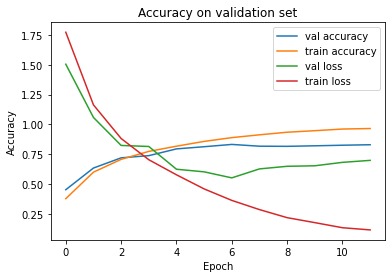

In [ ]:
fig = plt.figure()
numOfEpoch = 12
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='val accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='train accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='val loss')
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='train loss')

plt.title('Accuracy on validation set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()